In [1]:
import os, fnmatch
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, LSTM, Dropout, \
    Lambda, Input, Multiply, Layer, Conv1D, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger, \
    EarlyStopping, ModelCheckpoint
import tensorflow as tf
import soundfile as sf
from wavinfo import WavInfoReader
from random import shuffle, seed
import numpy as np

E:\conda\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
E:\conda\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
E:\conda\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
class audio_generator():
    '''
    Class to create a Tensorflow dataset based on an iterator from a large scale 
    audio dataset. This audio generator only supports single channel audio files.
    '''
    
    def __init__(self, path_to_farend_signal, path_to_nearend_speech, len_of_samples, fs, train_flag=False):
        '''
        Constructor of the audio generator class.
        Inputs:
            path_to_input       path to the mixtures
            path_to_s1          path to the target source data
            len_of_samples      length of audio snippets in samples
            fs                  sampling rate
            train_flag          flag for activate shuffling of files
        '''
        # set inputs to properties
        #self.path_to_nearend_signal = path_to_nearend_signal
        self.path_to_farend_signal = path_to_farend_signal
        self.path_to_nearend_speech = path_to_nearend_speech
        
        self.len_of_samples = len_of_samples
        self.fs = fs
        self.train_flag=train_flag
        # count the number of samples in your data set (depending on your disk,
        #                                               this can take some time)
        self.count_samples()
        # create iterable tf.data.Dataset object
        self.create_tf_data_obj()
        
    def count_samples(self):
        '''
        Method to list the data of the dataset and count the number of samples. 
        '''

        # list .wav files in directory
        self.file_names = fnmatch.filter(os.listdir(self.path_to_nearend_signal), '*.wav')
        # count the number of samples contained in the dataset
        self.total_samples = 0
        for file in self.file_names:
            info = WavInfoReader(os.path.join(self.path_to_nearend_signal, file))
            self.total_samples = self.total_samples + \
                int(np.fix(info.data.frame_count/self.len_of_samples))
    
         
    def create_generator(self):
        '''
        Method to create the iterator. 
        '''

        # check if training or validation
        if self.train_flag:
            shuffle(self.file_names)
        # iterate over the files  
        for file in self.file_names:
            # read the audio files
            #nearend_signal, fs_1 = sf.read(os.path.join(self.path_to_nearend_signal, file))
            farend_signal, fs_2 = sf.read(os.path.join(self.path_to_farend_signal, file.replace('nearend_mic','farend_speech')))
            nearend_speech, fs_3 = sf.read(os.path.join(self.path_to_nearend_speech, file.replace('nearend_mic','nearend_speech')))
            # check if the sampling rates are matching the specifications
            if fs_1 != self.fs or fs_2 != self.fs:
                raise ValueError('Sampling rates do not match.')
            if nearend_speech.ndim != 1 or farend_signal.ndim != 1:
                raise ValueError('Too many audio channels. The DTLN audio_generator \
                                 only supports single channel audio data.')
            # Random Sample
            
            if len(farend_signal) > self.len_of_samples:
                idx_seg = np.random.randint(0, len(input_audio)-remaining_length)
                farend_signal = farend_signal[idx_seg:idx_seg+self.len_of_samples]
            
            if len(nearend_speech) > self.len_of_samples:
                idx_seg = np.random.randint(0, len(input_audio)-remaining_length)
                nearend_speech = nearend_speech[idx_seg:idx_seg+self.len_of_samples]
            
            yield {"input_1": farend_signal_dat.astype('float32'), "input_2": nearend_signal_dat.astype('float32')},nearend_speech_dat.astype('float32')
              

    def create_tf_data_obj(self):
        '''
        Method to to create the tf.data.Dataset. 
        '''

        # creating the tf.data.Dataset from the iterator
        self.tf_data_set = tf.data.Dataset.from_generator(
                        self.create_generator,
                        output_types=({"input_1": tf.float32, "input_2": tf.float32}, tf.float32),
                        args=None
                        )

In [3]:
import librosa

In [59]:
audio_file_name='E:/intern/codes/dataset/RIR/small_room/Room001-00001.wav'
in_data,fs = librosa.core.load(audio_file_name, sr=16000, mono=True)

In [60]:
audio_file_name='E:/intern/codes/dataset/farend_signal/farend_speech_fileid_0.wav'
in_data2,fs = librosa.core.load(audio_file_name, sr=16000, mono=True)

In [138]:
audio_file_name='E:/intern/codes/dataset/RIR/small_room/Room001-00001.wav'
in_data2,fs = sf.read(audio_file_name)

In [139]:
audio_file_name='E:/intern/codes/dataset/farend_signal/farend_speech_fileid_0.wav'
in_data1,fs = sf.read(audio_file_name)

In [140]:
print(in_data1.mean())
print(in_data2.mean())

-4.869033727359234e-05
2.2365570068359377e-05


In [106]:
in_data1 = in_data1 / np.max(np.abs(in_data1))

In [142]:
in_data2 = in_data2 / np.max(np.abs(in_data2))

In [108]:
print(in_data1.mean())
print(in_data2.mean())

-0.00024177678008502397
0.0006953273244781785


In [109]:
from scipy import signal

In [143]:
signal_rev =signal.fftconvolve(in_data1,in_data2,mode="full")
#signal_rev = signal_rev / np.max(np.abs(signal_rev))
signal_rev = signal_rev[0 : in_data1.shape[0]]
sf.write('file_out.wav', signal_rev, fs)

In [111]:
signal_rev.mean()

-0.0006598926884704829

In [113]:
rms = (in_data1 ** 2).mean() ** 0.5

In [114]:
rms

0.15880297475233765

In [115]:
EPS = np.finfo(float).eps

In [116]:
target_level=-25

In [117]:
scalar = 10 ** (target_level / 20) / (rms+EPS)

In [119]:
audio = in_data1 * scalar

In [122]:
rms = (audio ** 2).mean() ** 0.5

In [123]:
rms

0.056234132519034835

In [124]:
20*np.log10(rms)

-25.000000000000014

In [136]:
import matplotlib.pyplot as plt

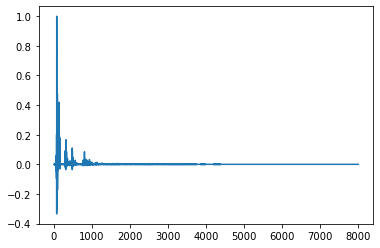

In [137]:
plt.plot(in_data2)

In [4]:
from scipy.signal import sosfiltfilt, butter

In [9]:
sos = butter(4, 0.125, output='sos')


In [10]:
sos

array([[ 9.33498613e-04,  1.86699723e-03,  9.33498613e-04,
         1.00000000e+00, -1.36511724e+00,  4.77592250e-01],
       [ 1.00000000e+00,  2.00000000e+00,  1.00000000e+00,
         1.00000000e+00, -1.61172710e+00,  7.44520838e-01]])